In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy
%matplotlib widget

In [77]:
jax.config.update("jax_enable_x64", True)

In [191]:
# @jax.jit
def midpoint_rule_first_(f, a, b ):
    """Midpoint rule for integration on [a,b] with N intervals"""
    return (b-a)*f((a+b)/2)
    
# @jax.jit
def midpoint_rule_next_(f, a, b, N, s ):
    """Midpoint rule for integration on [a,b] with N intervals"""
    it = 3**(N-2)
    delta = (b-a)/(3.0*it)
    sum= jnp.sum( f( jnp.arange(a+delta/2, b, 3*delta) ) )
    sum+= jnp.sum( f( jnp.arange(a+5*delta/2, b, 3*delta) ) )
    return (s+(b-a)*sum/it)/3.0

# @jax.jit
def midpoint_rule(f, a, b, epsabs=0.0, epsrel=1e-6):
    """Midpoint rule for integration on [a,b] with error control"""
    N = 2
    s_old = midpoint_rule_first_(f, a, b)
    s     = midpoint_rule_next_(f, a, b, N, s_old)
    while True:
        err = jnp.abs(s-s_old)
        if err<epsabs or err<epsrel*jnp.abs(s):
            return s
        s_old = s
        s = midpoint_rule_next_(f, a, b, N+1, s_old)
        N += 1
    # return s_old

# @jax.jit
def midpoint_zero_inf( f, epsabs=0.0, epsrel=1e-6 ):
    """Midpoint rule for integration on [0,inf] with error control"""""
    g = lambda x: f(-jnp.log(x)) / x
    return midpoint_rule( g, 0.0, 1.0, epsabs=epsabs, epsrel=epsrel )

In [197]:
## reference implementation with numpy/scipy
def Omega_nu_numpy_(a, mnu, Tcmb, h):
    # a is the scale factor
    # Tcmb is the temperature of the CMB
    # H0 is the Hubble constant
    # h is the reduced Hubble constant
    # Omega_nu is the density of neutrinos
    # Omega_nu = 7*pi^4/120 * (T_nu/T_cmb)^4 * (4/11)^(4/3) * (1/1.68)
    sum = 0.0
    for m in mnu:
        c2ok = 1.62581581e4 # K / eV
        beta = m/Tcmb * c2ok
        def integ(y):
            return y**2 * np.sqrt(1+y**2/a**2) / (np.exp(beta*y) + 1)
        res = scipy.integrate.quad(integ, 0, np.inf, epsabs=1e-13, epsrel=1e-10)
        sum += res[0] * (m/5.32e-3)**4
    return sum * a**-3

def Omega_nu_numpy( a, mnu, Tcmb, h ):
    res = np.zeros_like(a)
    for i, ai in enumerate(a):
        res[i] = Omega_nu_numpy_(ai, mnu, Tcmb, h)
    return res

In [198]:
@jax.jit
def integ_omega_nu(y, a, mnu, Tcmb):
    # a is the scale factor
    # Tcmb is the temperature of the CMB
    # H0 is the Hubble constant
    # h is the reduced Hubble constant
    # Omega_nu is the density of neutrinos
    # Omega_nu = 7*pi^4/120 * (T_nu/T_cmb)^4 * (4/11)^(4/3) * (1/1.68)
    c2ok = 1.62581581e4 # K / eV
    f = 0.0
    for m in mnu:
        beta = m/Tcmb * c2ok
        f += y**2 * jnp.sqrt(1.+y**2/a**2) / (jnp.exp(beta*y) + 1.) * (m/5.32e-3)**4
    return f

def Omega_nu_(a, mnu, Tcmb, h):
    res = midpoint_zero_inf( lambda y: integ_omega_nu(y,a,mnu,Tcmb), epsabs=0, epsrel=1e-6)
    return res * a**-3

def Omega_nu( a, mnu, Tcmb=2.7255, h=0.6736 ):
    res = jnp.zeros_like(a)
    for i, ai in enumerate(a):
        res = res.at[i].set( Omega_nu_(ai, mnu, Tcmb, h) )
    return res


/var/folders/m8/1yjz77r957vbsrx_2s2hdj1r0000gn/T/ipykernel_9466/874625509.py:14: RuntimeWarning: overflow encountered in exp
  return y**2 * np.sqrt(1+y**2/a**2) / (np.exp(beta*y) + 1)


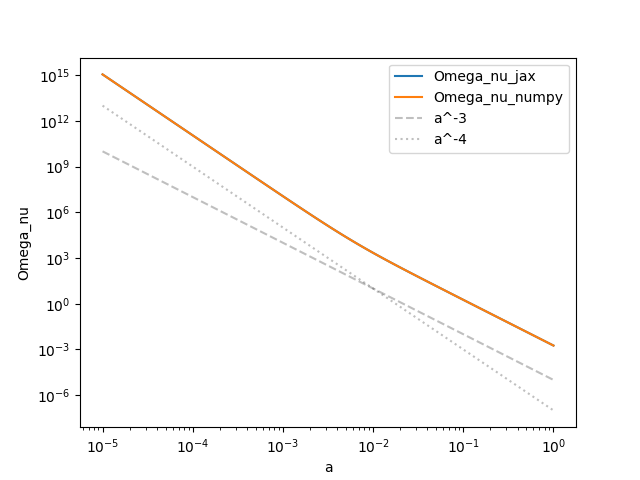

In [204]:
aa = jnp.geomspace(1e-5,1.0,100)

mnus = [0.1,0.07]

fig, ax = plt.subplots()
ax.loglog(aa, Omega_nu(aa, mnus, Tcmb=2.7255, h=0.67), label='Omega_nu_jax')
ax.loglog(aa, Omega_nu_numpy(aa, mnus, Tcmb=2.7255, h=0.67), label='Omega_nu_numpy')

ax.set_xlabel('a')
ax.set_ylabel('Omega_nu')
ax.loglog(aa,1e-5*aa**-3, c='k', ls='--', label='a^-3', alpha=0.25)
ax.loglog(aa,1e-7*aa**-4, c='k', ls=':',  label='a^-4', alpha=0.25)
ax.legend()
